# Pip Install

In [2]:
!pip install boto3 astropy sfdmap progressbar2 GPUtil parse

# Initialization

In [3]:
import GPUtil
print('GPUs:\n{0}'.format('\n'.join(['('+str(i+1)+')\t'+gpu.name+'\t-\t{:.2f}GB'.format(gpu.memoryFree/1e3) for i,gpu in enumerate(GPUtil.getGPUs())])))
N_GPUs = len(GPUtil.getGPUs())

# make sure tensorflow detect the GPUs
import tensorflow as tf
assert len(tf.config.list_physical_devices('GPU'))==N_GPUs, 'Not all GPUs are available!'

GPUs:
(1)	NVIDIA GeForce RTX 3090	-	24.27GB


2023-04-15 14:32:00.523100: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-15 14:32:00.563904: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 14:32:01.318839: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# imports
import pandas as pd
import numpy as np
import os
import sys
import pickle
import boto3
from matplotlib import pyplot as plt
import time

# random seed
seed = 42
np.random.seed(seed)

# local files paths
local_home_dir_path = os.path.expanduser("~")
local_work_dir_path = os.path.join(local_home_dir_path, 'thesis2')
local_code_dir_path = os.path.join(local_work_dir_path , 'code')

# S3 file paths
endpoint_url = 'https://s3-west.nrp-nautilus.io'
bucket_name = 'tau-astro'
prefix = 'almogh'
s3_work_dir_path = os.path.join(prefix, 'thesis2')
s3_data_dir_path = os.path.join(s3_work_dir_path , 'data')
s3_models_dir_path = os.path.join(s3_work_dir_path , 'models')
s3_final_table_csv_path = os.path.join(s3_data_dir_path, 'SDSS_DR16_all.csv')

s3_client = boto3.client("s3", endpoint_url=endpoint_url)

# adding code folder to path
sys.path.insert(1, local_code_dir_path)
from s3 import to_s3_npy, to_s3_pkl, from_s3_npy, from_s3_pkl, to_s3_fig
from s3 import log_s3, s3_save_TF_model, s3_load_TF_model, from_s3_pickle
from NN import DistanceLayer, SiameseModel, DistillationDataGenerator, L1, L2

# Not related - plotting SNR plot

In [5]:
gs_BigRF = from_s3_pickle(s3_client = s3_client, bucket_name = bucket_name, path_in_bucket = 'almogh/thesis2/data/BigRF/gs.pkl')

loading from uri: s3://tau-astro/almogh/thesis2/data/BigRF/gs.pkl


In [6]:
gs_SmallRF = from_s3_pickle(s3_client = s3_client, bucket_name = bucket_name, path_in_bucket = 'almogh/thesis2/data/SmallRF/gs.pkl')

loading from uri: s3://tau-astro/almogh/thesis2/data/SmallRF/gs.pkl


In [7]:
gs_SmallRF.snMedian.min()

19.00816

Text(0, 0.5, 'count')

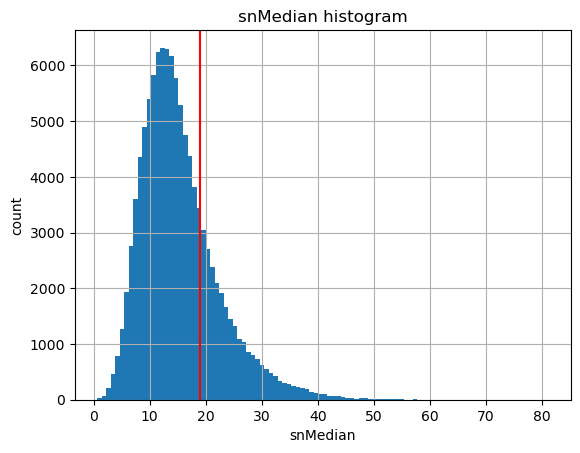

In [8]:
ax = gs_BigRF.snMedian.hist(bins=100)
ax.axvline(x = gs_SmallRF.snMedian.min(), color = 'r')
ax.set_title('snMedian histogram')
ax.set_xlabel('snMedian')
ax.set_ylabel('count')

# Load Model

In [9]:
# Load NN
batch_size = 128
NN = s3_load_TF_model(s3_client = s3_client,
                      bucket_name = bucket_name,
                      path_in_bucket = 'almogh/thesis2/models/NN2/train/after_35_epochs/model',
                      model_name = 'model',
                      custom_objects = {'DistanceLayer': DistanceLayer, 'L1':L1, 'L2':L2, 'SiameseModel':SiameseModel})

loading from uri: s3://tau-astro/almogh/thesis2/models/NN2/train/after_35_epochs/model
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


2023-04-15 14:32:06.717321: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22262 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:9c:00.0, compute capability: 8.6


# Loading distance matrices

In [12]:
s3_inference_dir_path_in_bucket = 'almogh/thesis2/eval/inference'
D_NN = from_s3_npy(s3_client = s3_client, bucket_name = bucket_name,
    path_in_bucket = os.path.join(s3_inference_dir_path_in_bucket,'D_NN2.npy'))
D_BigRF = from_s3_npy(s3_client = s3_client, bucket_name = bucket_name,
    path_in_bucket = os.path.join(s3_inference_dir_path_in_bucket,'D_BigRF.npy'))
D_SmallRF = from_s3_npy(s3_client = s3_client, bucket_name = bucket_name,
    path_in_bucket = os.path.join(s3_inference_dir_path_in_bucket,'D_SmallRF.npy'))

loading from uri: s3://tau-astro/almogh/thesis2/eval/inference/D_NN2.npy
loading from uri: s3://tau-astro/almogh/thesis2/eval/inference/D_BigRF.npy
loading from uri: s3://tau-astro/almogh/thesis2/eval/inference/D_SmallRF.npy


# Load data

In [13]:
# loading outliers
data_dir = 'almogh/thesis2/data/BigRF/train'
X = from_s3_npy(s3_client = s3_client, bucket_name = bucket_name, path_in_bucket = os.path.join(data_dir, 'spec.npy'))
gs = from_s3_pickle(s3_client = s3_client, bucket_name = bucket_name, path_in_bucket = os.path.join(data_dir, 'gs.pkl'))

loading from uri: s3://tau-astro/almogh/thesis2/data/BigRF/train/spec.npy
loading from uri: s3://tau-astro/almogh/thesis2/data/BigRF/train/gs.pkl


In [14]:
# loading outliers
outliers_data_dir = 'almogh/thesis2/data/Outliers'
X_outliers = from_s3_npy(s3_client = s3_client, bucket_name = bucket_name, path_in_bucket = os.path.join(outliers_data_dir, 'spec.npy'))
gs_outliers = from_s3_pickle(s3_client = s3_client, bucket_name = bucket_name, path_in_bucket = os.path.join(outliers_data_dir, 'gs.pkl'))

loading from uri: s3://tau-astro/almogh/thesis2/data/Outliers/spec.npy
loading from uri: s3://tau-astro/almogh/thesis2/data/Outliers/gs.pkl


In [15]:
# filtering low snr
snr_th = 3
I = gs_outliers.snMedian>snr_th
print('Filtering {0}/{1} outliers with SNR lower than {2}.'.format(len(gs_outliers)-sum(I),len(gs_outliers),snr_th))
X_outliers = X_outliers[I]
gs_outliers = gs_outliers[I]

Filtering 2/114 outliers with SNR lower than 3.


# Infer

In [37]:
SNRs = np.array([2,4,6,8,10,15,20])

In [85]:
n_noisy_inst = 4
batch_size = 128 # number of unique spectra from X per batch. actual batch size will be times n_noisy_inst

In [86]:
from tensorflow.keras import utils

class DataGenerator(utils.Sequence):

    def __init__(self, x_noisy_inst, X, batch_size):

        # saving arguments
        self.x_noisy_inst = x_noisy_inst
        self.X = X
        self.batch_size = batch_size
        
        # calculating min and max
        self.x_min = x_noisy_inst.min(axis=1)
        self.x_max = x_noisy_inst.max(axis=1)
        
        # creating outliers batch (each outlier is duplicated 
        self.n_noisy_inst = x_noisy_inst.shape[0]

    def __len__(self):
        return int(np.ceil(X.shape[0]/self.batch_size))

    def __getitem__(self, index):

        y = self.X[index*self.batch_size:(index+1)*self.batch_size]
        batch_size = y.shape[0]
        
        x = np.tile(self.x_noisy_inst, (batch_size,1))
        x_min = np.tile(self.x_min, batch_size)
        x_max = np.tile(self.x_max, batch_size)
        
        # prepare a batch of the data
        y_min = y.min(axis=1)
        y_max = y.max(axis=1)
        y = np.repeat(y, self.n_noisy_inst, axis=0)
        y_min = np.repeat(y_min, self.n_noisy_inst, axis=0)
        y_max = np.repeat(y_max, self.n_noisy_inst, axis=0)
        
        # normalize
        xy_min = np.stack((x_min,y_min),axis=1).min(axis=1).reshape(-1,1)
        x -= xy_min
        y -= xy_min
        xy_max = np.stack((x_max,y_max),axis=1).max(axis=1).reshape(-1,1)
        x /= xy_max
        y /= xy_max

        return (x,y),_

In [ ]:
from progressbar import progressbar
D_NN_outliers = np.zeros(shape=(len(gs_outliers), len(SNRs), X.shape[0]))
for i in range(len(gs_outliers)):
    print('outlier {0}/{1}'.format(i+1,len(gs_outliers)))
    x_i = X_outliers[i].reshape(1,-1)
    std_sqrd_i = np.std(x_i)**2
    for i_snr,snr in enumerate(SNRs):
        print('snr={0}, {1}/{2}'.format(snr, i_snr+1, len(SNRs)))
        
        # preparing a noisy batch of the outlier for this snr
        N_std_x = np.sqrt(std_sqrd_i/snr)
        x_noisy_inst = np.repeat(x_i, n_noisy_inst, axis=0)
        x_noisy_inst += N_std_x*np.random.randn(x_noisy_inst.shape[0], x_noisy_inst.shape[1])

        # infer
        data_gen = DataGenerator(x_noisy_inst, X, batch_size)
        d_vec = NN.predict(data_gen)
        D_NN_outliers[i,i_snr,:] = np.array([np.mean(d_vec[j*n_noisy_inst:(j+1)*n_noisy_inst]) for j in range(X.shape[0])])

outlier 1/112
snr=2, 1/7


2023-04-15 17:37:03.845167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 53s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-15 17:37:57.853525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  2/782 [..............................] - ETA: 51s

2023-04-15 17:38:50.126378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  2/782 [..............................] - ETA: 51s 

2023-04-15 17:39:42.573499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  2/782 [..............................] - ETA: 51s

2023-04-15 17:40:34.952348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  2/782 [..............................] - ETA: 51s

2023-04-15 17:41:27.432801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  2/782 [..............................] - ETA: 51s 

2023-04-15 17:42:19.867865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 2/112
snr=2, 1/7
  2/782 [..............................] - ETA: 47s 

2023-04-15 17:43:12.356115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  2/782 [..............................] - ETA: 49s 

2023-04-15 17:44:04.791417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  2/782 [..............................] - ETA: 51s

2023-04-15 17:44:57.245291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  2/782 [..............................] - ETA: 51s

2023-04-15 17:45:49.737709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  2/782 [..............................] - ETA: 51s 

2023-04-15 17:46:42.259627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  2/782 [..............................] - ETA: 50s 

2023-04-15 17:47:34.832295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 49s

2023-04-15 17:48:27.211234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 3/112
snr=2, 1/7
  2/782 [..............................] - ETA: 50s 

2023-04-15 17:49:19.681698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  2/782 [..............................] - ETA: 51s 

2023-04-15 17:50:12.042140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 17:51:04.519044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  2/782 [..............................] - ETA: 51s

2023-04-15 17:51:56.944599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 17:52:49.325746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 17:53:41.697853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  2/782 [..............................] - ETA: 51s 

2023-04-15 17:54:34.095942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 4/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 17:55:26.530657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  2/782 [..............................] - ETA: 53s 

2023-04-15 17:56:18.868817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  2/782 [..............................] - ETA: 51s

2023-04-15 17:57:11.232914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 49s

2023-04-15 17:58:03.595029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 17:58:55.943375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-15 17:59:48.419446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  2/782 [..............................] - ETA: 51s 

2023-04-15 18:00:40.735476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 5/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:01:33.128016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  2/782 [..............................] - ETA: 49s

2023-04-15 18:02:25.498143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  2/782 [..............................] - ETA: 51s

2023-04-15 18:03:18.008301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-15 18:04:10.403606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-15 18:05:02.815762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:05:55.281073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:06:47.690624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 6/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:07:40.053458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:08:32.346787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  2/782 [..............................] - ETA: 51s 

2023-04-15 18:09:24.748830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:10:17.092401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  2/782 [..............................] - ETA: 51s

2023-04-15 18:11:09.493538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:12:01.944223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  2/782 [..............................] - ETA: 51s

2023-04-15 18:12:54.313463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 7/112
snr=2, 1/7
  3/782 [..............................] - ETA: 49s

2023-04-15 18:13:46.745319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-15 18:14:39.048467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:15:31.401067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-15 18:16:23.858692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  2/782 [..............................] - ETA: 51s

2023-04-15 18:17:16.234623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:18:08.620957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  2/782 [..............................] - ETA: 52s

2023-04-15 18:19:01.005949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 8/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:19:53.465072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-15 18:20:45.798325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:21:38.096913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:22:30.540287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:23:22.893818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:24:15.249990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:25:07.696527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 9/112
snr=2, 1/7
  2/782 [..............................] - ETA: 51s

2023-04-15 18:26:00.034920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-15 18:26:52.389788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:27:44.723226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:28:37.062136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:29:29.459459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:30:21.805861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-15 18:31:14.217910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 10/112
snr=2, 1/7
  2/782 [..............................] - ETA: 51s

2023-04-15 18:32:06.546859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  2/782 [..............................] - ETA: 51s

2023-04-15 18:32:58.923919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:33:51.398184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:34:43.814297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-15 18:35:36.214089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:36:28.673281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:37:21.023812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 11/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:38:13.362068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  2/782 [..............................] - ETA: 51s

2023-04-15 18:39:05.747967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-15 18:39:58.280385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:40:50.638561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-15 18:41:42.959611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-15 18:42:35.325044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  2/782 [..............................] - ETA: 51s

2023-04-15 18:43:27.660494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 12/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:44:20.028181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:45:12.424506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:46:04.798436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:46:57.151846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:47:49.674079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:48:42.114161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 52s

2023-04-15 18:49:34.486254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 13/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:50:26.838764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:51:19.321527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:52:11.738313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  2/782 [..............................] - ETA: 51s

2023-04-15 18:53:04.070940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:53:56.555700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-15 18:54:48.901450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-15 18:55:41.222661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 14/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:56:33.637271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:57:26.049860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:58:18.450747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 18:59:10.781207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:00:03.035506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-15 19:00:55.510449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:01:47.782808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 15/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:02:40.130843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-15 19:03:32.545565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-15 19:04:24.917958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:05:17.227807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-15 19:06:09.720461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:07:02.075867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 49s

2023-04-15 19:07:54.420058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 16/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:08:46.770835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:09:39.080781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-15 19:10:31.364124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:11:23.560883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-15 19:12:15.898690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:13:08.171212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:14:00.607090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 17/112
snr=2, 1/7
  2/782 [..............................] - ETA: 50s

2023-04-15 19:14:52.859464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-15 19:15:45.165099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-15 19:16:37.470828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-15 19:17:29.678291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-15 19:18:21.978763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:19:14.196192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:20:06.528604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 18/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-15 19:20:58.791278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:21:51.112431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:22:43.422090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:23:35.872455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  2/782 [..............................] - ETA: 51s

2023-04-15 19:24:28.303812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:25:20.814279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  2/782 [..............................] - ETA: 51s

2023-04-15 19:26:13.335609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 19/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:27:05.864427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:27:58.368196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 52s

2023-04-15 19:28:50.840921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  2/782 [..............................] - ETA: 51s 

2023-04-15 19:29:43.375828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:30:35.901142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-15 19:31:28.399026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-15 19:32:20.913400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 20/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:33:13.459747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  2/782 [..............................] - ETA: 52s

2023-04-15 19:34:05.977932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 52s

2023-04-15 19:34:58.616235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 52s

2023-04-15 19:35:51.201917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:36:43.784900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 52s

2023-04-15 19:37:36.338619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:38:28.926107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 21/112
snr=2, 1/7
  2/782 [..............................] - ETA: 50s

2023-04-15 19:39:21.616339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:40:14.249390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-15 19:41:06.836460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-15 19:41:59.383939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-15 19:42:51.916780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:43:44.512546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:44:37.461096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 22/112
snr=2, 1/7
  2/782 [..............................] - ETA: 51s

2023-04-15 19:45:30.042893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  2/782 [..............................] - ETA: 50s 

2023-04-15 19:46:22.636550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  2/782 [..............................] - ETA: 50s 

2023-04-15 19:47:15.220936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  2/782 [..............................] - ETA: 52s 

2023-04-15 19:48:07.855407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-15 19:49:00.360134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:49:53.015620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-15 19:50:45.589661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 23/112
snr=2, 1/7
  2/782 [..............................] - ETA: 52s 

2023-04-15 19:51:38.149309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  2/782 [..............................] - ETA: 53s

2023-04-15 19:52:30.762196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  2/782 [..............................] - ETA: 52s

2023-04-15 19:53:23.368339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  2/782 [..............................] - ETA: 52s

2023-04-15 19:54:15.942606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:55:08.498619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  2/782 [..............................] - ETA: 53s

2023-04-15 19:56:01.036102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:56:53.617172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 24/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-15 19:57:46.257409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 19:58:38.818330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 49s

2023-04-15 19:59:31.331956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  2/782 [..............................] - ETA: 51s

2023-04-15 20:00:23.872605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:01:16.483205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  2/782 [..............................] - ETA: 51s

2023-04-15 20:02:09.037549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:03:01.550112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 25/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:03:54.110409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  2/782 [..............................] - ETA: 51s 

2023-04-15 20:04:46.746172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  2/782 [..............................] - ETA: 53s

2023-04-15 20:05:39.343737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  2/782 [..............................] - ETA: 49s

2023-04-15 20:06:31.941162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:07:24.618897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 52s

2023-04-15 20:08:17.103076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  2/782 [..............................] - ETA: 51s

2023-04-15 20:09:09.536638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 26/112
snr=2, 1/7
  2/782 [..............................] - ETA: 49s 

2023-04-15 20:10:02.204198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  2/782 [..............................] - ETA: 52s

2023-04-15 20:10:54.725917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  2/782 [..............................] - ETA: 51s 

2023-04-15 20:11:47.227255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:12:39.783946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:13:32.290637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  2/782 [..............................] - ETA: 51s

2023-04-15 20:14:24.782656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  2/782 [..............................] - ETA: 51s 

2023-04-15 20:15:17.369761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 27/112
snr=2, 1/7
  2/782 [..............................] - ETA: 51s 

2023-04-15 20:16:09.970382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  2/782 [..............................] - ETA: 51s

2023-04-15 20:17:02.523173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:17:55.064781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  2/782 [..............................] - ETA: 52s

2023-04-15 20:18:47.677526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-15 20:19:40.218335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:20:32.728280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:21:25.287359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 28/112
snr=2, 1/7
  2/782 [..............................] - ETA: 50s

2023-04-15 20:22:17.873791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  2/782 [..............................] - ETA: 51s

2023-04-15 20:23:10.470616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  2/782 [..............................] - ETA: 50s

2023-04-15 20:24:03.004882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  2/782 [..............................] - ETA: 51s

2023-04-15 20:24:55.595814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  2/782 [..............................] - ETA: 52s

2023-04-15 20:25:48.178622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:26:40.669038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-15 20:27:33.188421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 29/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:28:25.834127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:29:18.486229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  2/782 [..............................] - ETA: 51s 

2023-04-15 20:30:11.004015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:31:03.561508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:31:56.111760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  2/782 [..............................] - ETA: 51s 

2023-04-15 20:32:48.680403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  2/782 [..............................] - ETA: 50s

2023-04-15 20:33:41.297839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 30/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:34:33.916090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:35:26.555883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  2/782 [..............................] - ETA: 52s 

2023-04-15 20:36:19.157630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  2/782 [..............................] - ETA: 50s 

2023-04-15 20:37:11.796832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  2/782 [..............................] - ETA: 51s

2023-04-15 20:38:04.324017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:38:56.951996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:39:49.469246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 31/112
snr=2, 1/7
  2/782 [..............................] - ETA: 51s

2023-04-15 20:40:42.042553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  2/782 [..............................] - ETA: 51s 

2023-04-15 20:41:34.617001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  2/782 [..............................] - ETA: 51s 

2023-04-15 20:42:27.138127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  2/782 [..............................] - ETA: 51s 

2023-04-15 20:43:19.730077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:44:12.237769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:45:04.767148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:45:57.292719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 32/112
snr=2, 1/7
  2/782 [..............................] - ETA: 50s

2023-04-15 20:46:49.832820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  2/782 [..............................] - ETA: 51s 

2023-04-15 20:47:42.372519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:48:34.965432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:49:27.556353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:50:20.149454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:51:12.748990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:52:05.288468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 33/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:52:57.861845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 49s

2023-04-15 20:53:50.330736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:54:42.793213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:55:35.357269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-15 20:56:27.918520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:57:20.461377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:58:13.002098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 34/112
snr=2, 1/7
  2/782 [..............................] - ETA: 50s

2023-04-15 20:59:05.566659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 20:59:58.140567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:00:50.673101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:01:43.200516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  2/782 [..............................] - ETA: 51s

2023-04-15 21:02:35.712263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 52s

2023-04-15 21:03:28.249097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:04:20.845681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 35/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:05:13.396192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:06:06.041168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  2/782 [..............................] - ETA: 51s

2023-04-15 21:06:58.672506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:07:51.175386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:08:43.751554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  2/782 [..............................] - ETA: 51s

2023-04-15 21:09:36.376699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:10:28.960462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 36/112
snr=2, 1/7
  2/782 [..............................] - ETA: 51s 

2023-04-15 21:11:21.514253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  2/782 [..............................] - ETA: 50s

2023-04-15 21:12:14.046147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:13:06.669669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  2/782 [..............................] - ETA: 51s 

2023-04-15 21:13:59.243486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:14:51.824064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  2/782 [..............................] - ETA: 51s

2023-04-15 21:15:44.357322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  2/782 [..............................] - ETA: 51s

2023-04-15 21:16:37.044257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 37/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-15 21:17:29.688989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  2/782 [..............................] - ETA: 49s 

2023-04-15 21:18:22.265553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  2/782 [..............................] - ETA: 50s

2023-04-15 21:19:14.822049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  2/782 [..............................] - ETA: 49s 

2023-04-15 21:20:07.322473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  2/782 [..............................] - ETA: 51s

2023-04-15 21:21:00.060129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  2/782 [..............................] - ETA: 51s 

2023-04-15 21:21:52.724081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 67ms/step
snr=20, 7/7
  2/782 [..............................] - ETA: 51s 

2023-04-15 21:22:45.527929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 38/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:23:38.100373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  2/782 [..............................] - ETA: 51s

2023-04-15 21:24:30.645480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:25:23.136096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:26:15.699506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  2/782 [..............................] - ETA: 50s

2023-04-15 21:27:08.131911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:28:00.545452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:28:52.905474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 39/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:29:45.290471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-15 21:30:37.739605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  2/782 [..............................] - ETA: 50s

2023-04-15 21:31:30.133496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:32:22.500342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:33:14.927169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-15 21:34:07.306121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-15 21:34:59.728897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 40/112
snr=2, 1/7
  2/782 [..............................] - ETA: 51s

2023-04-15 21:35:52.137921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  2/782 [..............................] - ETA: 51s

2023-04-15 21:36:44.501743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  2/782 [..............................] - ETA: 49s

2023-04-15 21:37:36.919516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-15 21:38:29.380865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-15 21:39:21.771937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:40:14.119652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  2/782 [..............................] - ETA: 51s

2023-04-15 21:41:06.541637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 41/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:41:59.013543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:42:51.495367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-15 21:43:43.907830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:44:36.291158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-15 21:45:28.711774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  2/782 [..............................] - ETA: 51s

2023-04-15 21:46:21.101416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:47:13.575728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 42/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:48:05.966213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:48:58.345794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:49:50.710927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:50:43.288127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:51:35.721727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:52:28.232285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:53:20.604726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 43/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-15 21:54:12.968148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-15 21:55:05.298004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-15 21:55:57.687324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:56:50.199243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  2/782 [..............................] - ETA: 50s 

2023-04-15 21:57:42.680054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 21:58:35.178155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  2/782 [..............................] - ETA: 50s

2023-04-15 21:59:27.561186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 44/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-15 22:00:20.052299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:01:12.453010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-15 22:02:04.954562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-15 22:02:57.387679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-15 22:03:49.797016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 52s

2023-04-15 22:04:42.381951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:05:34.857133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 45/112
snr=2, 1/7
  2/782 [..............................] - ETA: 51s

2023-04-15 22:06:27.234458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:07:19.643462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-15 22:08:12.199158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-15 22:09:04.548732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:09:56.886024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:10:49.264699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:11:41.708764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 46/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-15 22:12:34.175910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:13:26.521194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:14:18.956894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:15:11.286335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:16:03.656571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 49s

2023-04-15 22:16:56.129929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-15 22:17:48.561235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 47/112
snr=2, 1/7
  2/782 [..............................] - ETA: 51s

2023-04-15 22:18:40.923033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-15 22:19:33.282780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-15 22:20:25.634719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:21:18.095729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:22:10.529312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-15 22:23:02.908077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:23:55.225712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 48/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:24:47.659096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:25:39.996181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:26:32.389388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-15 22:27:24.752852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-15 22:28:17.059219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:29:09.491905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:30:01.848538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 49/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:30:54.236218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-15 22:31:46.706631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:32:39.026682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:33:31.407162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:34:23.761828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:35:16.175964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-15 22:36:08.585418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 50/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:37:01.026586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-15 22:37:53.447083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-15 22:38:45.866746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:39:38.214188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 50s 64ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:40:29.048506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 53s 67ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:41:22.589593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 67ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 49s

2023-04-15 22:42:15.356660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 51/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:43:07.915649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-15 22:44:00.363503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:44:52.782148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:45:45.220663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:46:37.653517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:47:30.075976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:48:22.503401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 52/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:49:14.992321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:50:07.342144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:50:59.772010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-15 22:51:52.230128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:52:44.600614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:53:37.004777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-15 22:54:29.438499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 53/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:55:21.834367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:56:14.308283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-15 22:57:06.724245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  2/782 [..............................] - ETA: 51s

2023-04-15 22:57:59.043454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 22:58:51.467086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 52s

2023-04-15 22:59:43.872116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 52s

2023-04-15 23:00:36.254583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 54/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-15 23:01:28.680105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:02:20.990618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:03:13.369954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:04:05.690072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:04:58.102705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-15 23:05:50.471580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 52s

2023-04-15 23:06:42.921953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 55/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-15 23:07:35.343273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-15 23:08:27.748681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:09:20.147733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  2/782 [..............................] - ETA: 51s

2023-04-15 23:10:12.603557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-15 23:11:05.069002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:11:57.476873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:12:49.917356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 56/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:13:42.333691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:14:34.773725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-15 23:15:27.138436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:16:19.502450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:17:11.964462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:18:04.356185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:18:56.761277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 57/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:19:49.159068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:20:41.589199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:21:33.948999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-15 23:22:26.350015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:23:18.800945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-15 23:24:11.228189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-15 23:25:03.634691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 58/112
snr=2, 1/7
  2/782 [..............................] - ETA: 50s

2023-04-15 23:25:56.044808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:26:48.468592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:27:40.938474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-15 23:28:33.262104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:29:25.610916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-15 23:30:18.005223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-15 23:31:10.353096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 59/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:32:02.782117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-15 23:32:55.151653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 49s

2023-04-15 23:33:47.631741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:34:39.990527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  2/782 [..............................] - ETA: 51s

2023-04-15 23:35:32.502996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:36:24.864197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-15 23:37:17.258921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 60/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:38:09.622035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:39:02.094133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:39:54.490362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:40:46.912380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-15 23:41:39.289336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-15 23:42:31.742780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:43:24.075980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 61/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:44:16.951942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-15 23:45:09.325444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:46:01.679039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:46:54.045689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:47:46.334665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:48:38.692858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-15 23:49:30.980381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 62/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-15 23:50:23.248552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:51:15.507355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-15 23:52:07.795165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-15 23:53:00.107404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-15 23:53:52.423649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:54:44.753844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:55:36.992277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 63/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:56:29.280219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-15 23:57:21.528082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:58:13.821947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:59:06.208278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-15 23:59:58.520010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:00:50.806142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:01:43.153046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 64/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:02:35.480340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:03:27.834475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:04:20.064890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:05:12.393598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:06:04.644397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:06:56.902570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:07:49.251323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 65/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:08:41.531630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:09:33.842900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:10:26.149586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:11:18.400955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:12:10.646359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:13:02.992339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:13:55.251365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 66/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:14:47.532281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:15:39.767920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:16:32.074829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:17:24.385072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:18:16.774180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:19:09.053464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:20:01.354431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 67/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:20:53.673652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:21:46.010883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:22:38.338785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:23:30.660666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  2/782 [..............................] - ETA: 51s

2023-04-16 00:24:23.040122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:25:15.329861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:26:07.650864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 68/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:26:59.938994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:27:52.295339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:28:44.618418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:29:37.014780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:30:29.347282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:31:21.613944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:32:13.908808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 69/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:33:06.228406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:33:58.544284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:34:50.780909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:35:43.040970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:36:35.350398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:37:27.683857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:38:19.979244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 70/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:39:12.286368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:40:04.603338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:40:56.961261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:41:49.278645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:42:41.548585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:43:33.880946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:44:26.257313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
outlier 71/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:45:18.483758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:46:10.829172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:47:03.121666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:47:55.415533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:48:47.657597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:49:39.925261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:50:32.155562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 72/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:51:24.405276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:52:16.678872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:53:08.995696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:54:01.325336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 00:54:53.651227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:55:46.025491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:56:38.299192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 73/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:57:30.589131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:58:22.944412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 00:59:15.225414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:00:07.496502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:00:59.871619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:01:52.167659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:02:44.501593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 74/112
snr=2, 1/7
  2/782 [..............................] - ETA: 52s

2023-04-16 01:03:36.836648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:04:29.178247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:05:21.484476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:06:13.840395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:07:06.148217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:07:58.426513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:08:50.660902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 75/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:09:43.063237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:10:35.312467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 52s

2023-04-16 01:11:27.640940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:12:19.929573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:13:12.228916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:14:04.530289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:14:56.891082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 76/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:15:49.250590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:16:41.560354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:17:33.835385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:18:26.120531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:19:18.464213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:20:10.740519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:21:03.002846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 77/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:21:55.343142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:22:47.746145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:23:40.194337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 52s

2023-04-16 01:24:32.481964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:25:24.803753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:26:17.142557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:27:09.449585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 78/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:28:01.836858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:28:54.136245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:29:46.535764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:30:38.887747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=10, 5/7
  2/782 [..............................] - ETA: 51s

2023-04-16 01:31:31.157659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:32:23.489292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:33:15.801987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 79/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:34:08.108669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:35:00.461493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:35:52.732151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:36:45.007887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:37:37.329504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 53s

2023-04-16 01:38:29.617384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:39:21.931294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 80/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:40:14.202316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:41:06.531219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:41:58.869002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:42:51.147637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:43:43.470944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:44:35.821386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:45:28.140864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 81/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:46:20.469352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:47:12.826821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:48:05.129425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:48:57.461418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:49:49.799472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:50:42.073650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:51:34.452830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 82/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:52:26.815659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:53:19.124761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  2/782 [..............................] - ETA: 51s

2023-04-16 01:54:11.459059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:55:03.725714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  2/782 [..............................] - ETA: 51s

2023-04-16 01:55:56.071758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:56:48.411726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:57:40.763035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 83/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-16 01:58:33.099862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-16 01:59:25.435854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:00:17.710380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:01:09.995728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:02:02.302173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:02:54.640580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:03:46.940512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 84/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:04:39.266738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:05:31.496528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  2/782 [..............................] - ETA: 50s

2023-04-16 02:06:23.845115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:07:16.179112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:08:08.468133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:09:00.841450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:09:53.097909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 85/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:10:45.461600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:11:37.719036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:12:29.996686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:13:22.404508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:14:14.710483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 52s

2023-04-16 02:15:07.071930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:15:59.348815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 86/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:16:51.631791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 54s

2023-04-16 02:17:43.905817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:18:36.217391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:19:28.459885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  2/782 [..............................] - ETA: 51s

2023-04-16 02:20:20.809065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:21:13.182720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:22:05.482683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 87/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:22:57.845327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:23:50.180784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:24:42.523580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:25:34.864814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:26:27.109277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:27:19.418613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:28:11.689440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 88/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:29:03.998753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:29:56.363799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:30:48.692491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:31:40.972958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:32:33.227715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:33:25.554907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:34:17.825871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 89/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:35:10.107968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:36:02.369161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:36:54.718823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:37:47.129425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:38:39.468566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:39:31.763252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:40:24.108890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 90/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:41:16.456127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:42:08.776004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:43:01.123422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:43:53.485157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:44:45.760480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:45:38.078872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:46:30.360051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 91/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:47:22.691961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 49s

2023-04-16 02:48:15.023964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:49:07.356129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 52s

2023-04-16 02:49:59.614361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:50:51.889256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:51:44.208115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=20, 7/7
  2/782 [..............................] - ETA: 49s

2023-04-16 02:52:36.512655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 92/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:53:28.790795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:54:21.119168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:55:13.383156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:56:05.755516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 49s

2023-04-16 02:56:58.124300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:57:50.396429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 02:58:42.714566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 93/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 02:59:35.041231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:00:27.353541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:01:19.620815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:02:11.980986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:03:04.346536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:03:56.683127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:04:49.030401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 94/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:05:41.355401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:06:33.681720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:07:25.983132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:08:18.323452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:09:10.689398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:10:03.082402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:10:55.359515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 95/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:11:47.673891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:12:40.046786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:13:32.325338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:14:24.674848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:15:16.990018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:16:09.318560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:17:01.708597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 96/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:17:54.046487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:18:46.401362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  2/782 [..............................] - ETA: 51s 

2023-04-16 03:19:38.771482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:20:31.111609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:21:23.388707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:22:15.738342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:23:08.080658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 97/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:24:00.367138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:24:52.655234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:25:45.025534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:26:37.346473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:27:29.641607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:28:21.986969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:29:14.290153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 98/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:30:06.645558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:30:58.936985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:31:51.361583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:32:43.729233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:33:36.049389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:34:28.424951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:35:20.857782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 99/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:36:13.317684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:37:05.768403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:37:58.199863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:38:50.659314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:39:43.032321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:40:35.452568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:41:27.909699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 100/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:42:20.354237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:43:12.745151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:44:05.263551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:44:57.631995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:45:50.042006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:46:42.464569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:47:34.836316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 101/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:48:27.287449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  2/782 [..............................] - ETA: 52s

2023-04-16 03:49:19.669831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:50:12.092692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:51:04.534874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:51:56.926797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:52:49.362631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:53:41.919219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 102/112
snr=2, 1/7
  2/782 [..............................] - ETA: 51s 

2023-04-16 03:54:34.555507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:55:27.006942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:56:19.441153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 03:57:11.842293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:58:04.278622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  2/782 [..............................] - ETA: 52s

2023-04-16 03:58:56.734995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 03:59:49.190616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 103/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:00:41.600265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:01:34.018188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:02:26.480440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  2/782 [..............................] - ETA: 50s

2023-04-16 04:03:19.000454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:04:11.474751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:05:03.922408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  2/782 [..............................] - ETA: 51s

2023-04-16 04:05:56.576423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 104/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:06:49.096868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:07:41.561850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 04:08:34.112984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:09:26.574927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:10:19.108169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-16 04:11:11.635146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:12:04.142880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 105/112
snr=2, 1/7
  2/782 [..............................] - ETA: 51s

2023-04-16 04:12:56.635417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  2/782 [..............................] - ETA: 51s

2023-04-16 04:13:49.166749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:14:41.665591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:15:34.304132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:16:26.818433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 53s

2023-04-16 04:17:19.277930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:18:11.739695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 106/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 04:19:04.135121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:19:56.510927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 04:20:48.960545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 04:21:41.315092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:22:33.722461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-16 04:23:26.224448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:24:18.702965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 107/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 04:25:11.094245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:26:03.557968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 50s

2023-04-16 04:26:55.940656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:27:48.332129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-16 04:28:40.675880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 50s

2023-04-16 04:29:32.906274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:30:25.082273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
outlier 108/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 04:31:17.309796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:32:09.548717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  2/782 [..............................] - ETA: 54s

2023-04-16 04:33:02.034768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 52s

2023-04-16 04:33:54.393919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 50s

2023-04-16 04:34:46.632793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:35:38.930050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:36:31.197095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 109/112
snr=2, 1/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:37:23.517838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:38:15.676655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 53s

2023-04-16 04:39:08.097816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 04:40:00.404853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:40:52.829697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:41:45.281332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=20, 7/7
  3/782 [..............................] - ETA: 50s

2023-04-16 04:42:37.481865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
outlier 110/112
snr=2, 1/7
  3/782 [..............................] - ETA: 50s

2023-04-16 04:43:29.808861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=4, 2/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:44:22.086608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=6, 3/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:45:14.443678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=8, 4/7
  3/782 [..............................] - ETA: 50s

2023-04-16 04:46:06.725478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 52s 66ms/step
snr=10, 5/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:46:59.001517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 51s 66ms/step
snr=15, 6/7
  3/782 [..............................] - ETA: 51s

2023-04-16 04:47:51.260557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 39/782 [>.............................] - ETA: 48s

In [ ]:
to_s3_npy(D_NN_outliers, s3_client = s3_client, bucket_name = bucket_name, path_in_bucket = 'almogh/thesis2/eval/D_NN2_outliers.npy')